In [125]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [126]:
mineralFilePath = 'EMIT_L2B_MIN_001_20220811T001233_2222216_001.nc'
reflectanceFilePath = 'EMIT_L2A_RFL_001_20220811T001233_2222216_001.nc'

In [127]:
refl = xr.open_dataset(reflectanceFilePath)
minerals = xr.open_dataset(mineralFilePath)

In [128]:
hsiData = refl['reflectance'].values
hsiData.shape
del refl

In [129]:
groundTruth = minerals.group_1_mineral_id.values
groundTruth.shape
del minerals

In [130]:
X = hsiData.reshape(-1, hsiData.shape[2])
y = groundTruth.ravel()

In [131]:
X = pd.DataFrame(X)
X['gt'] = y
X.head()

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,gt
0,0.010281,0.010403,0.010525,0.010649,0.010932,0.011388,0.011972,0.012628,0.013215,0.013814,...,0.021460,0.021286,0.021945,0.021045,0.020107,0.018974,0.019383,0.018503,0.017791,0.0
1,0.011180,0.011382,0.011583,0.011786,0.012148,0.012683,0.013340,0.014069,0.014724,0.015389,...,0.026586,0.025946,0.026113,0.025691,0.024153,0.024572,0.023118,0.022323,0.021669,0.0
2,0.012435,0.012749,0.013063,0.013379,0.013852,0.014502,0.015266,0.016096,0.016839,0.017584,...,0.032494,0.029946,0.029996,0.027479,0.028405,0.026994,0.026503,0.025581,0.024835,0.0
3,0.017038,0.017625,0.018211,0.018801,0.019578,0.020565,0.021674,0.022856,0.023913,0.024962,...,0.051407,0.048852,0.048247,0.044599,0.044867,0.044043,0.041095,0.039858,0.039054,0.0
4,0.017849,0.018292,0.018735,0.019183,0.019864,0.020798,0.021901,0.023103,0.024190,0.025284,...,0.051231,0.049668,0.051017,0.044889,0.045879,0.043703,0.040889,0.039307,0.039314,0.0


In [132]:
X = X.loc[:, ~(X == -0.01).any()]

In [133]:
min32 = X.query('gt == 32')
min45 = X.query('gt == 45')
min20 = X.query('gt == 20')

In [134]:
merged = pd.concat([min32, min45, min20])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10524 entries, 11577 to 1589690
Columns: 245 entries, 0 to gt
dtypes: float32(245)
memory usage: 9.9 MB


In [135]:
X = merged
y = merged.pop('gt')
del hsiData
del groundTruth

In [136]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({32.0: 4056, 45.0: 3960, 20.0: 2508})


<BarContainer object of 3 artists>

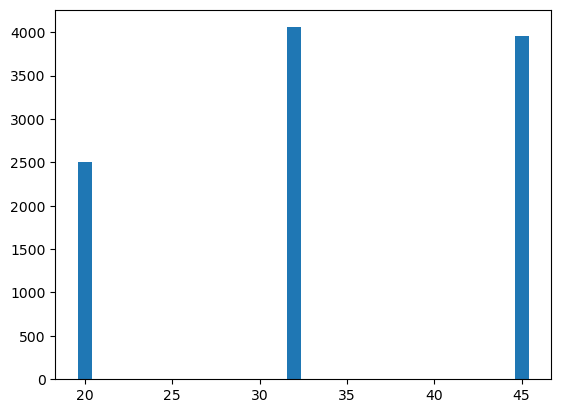

In [137]:
plt.bar(counter.keys(), counter.values())

In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

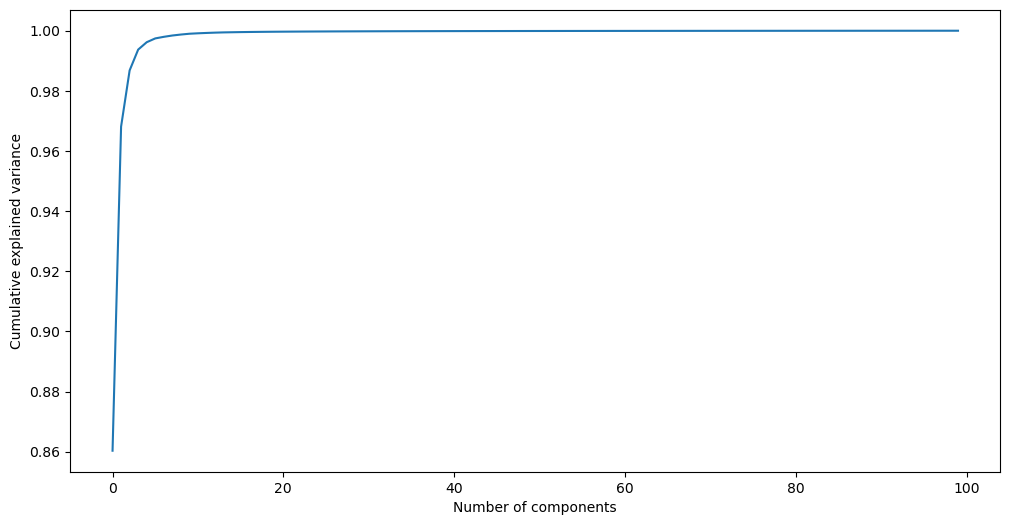

In [139]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)

principalComponents = pca.fit_transform(X)

X = principalComponents

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
print(X_train.shape)

(5262, 100)


In [117]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({32.0: 2028, 45.0: 1980, 20.0: 1254})


In [118]:
def class_weight(labels_dict,mu=0.15):
	total = np.sum(np.fromiter(labels_dict.values(), dtype=int))
	keys = labels_dict.keys()
	weight = dict()
	for i in keys:
		score = np.log(mu*total/int(labels_dict[i]))
		weight[i] = score if score > 1 else 1
	return weight

In [119]:
weights = class_weight(Counter(y_train))
weights

{20.0: 1, 32.0: 1, 45.0: 1}

In [159]:
from sklearn.svm import SVC
model = SVC(C=10, gamma=1, kernel='linear', class_weight='balanced')
model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma=1, kernel='linear')

In [160]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pred = model.predict(X_test)
clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
print("Test Result:n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: n {confusion_matrix(y_test, pred)}n")

Test Result:n================================================
Accuracy Score: 95.84%
_______________________________________________
CLASSIFICATION REPORT:n                  20.0         32.0         45.0  accuracy    macro avg  \
precision     0.932412     0.976813     0.956544  0.958381     0.955256   
recall        0.968102     0.976331     0.933838  0.958381     0.959424   
f1-score      0.949922     0.976572     0.945055  0.958381     0.957183   
support    1254.000000  2028.000000  1980.000000  0.958381  5262.000000   

           weighted avg  
precision      0.958605  
recall         0.958381  
f1-score       0.958362  
support     5262.000000  
_______________________________________________
Confusion Matrix: n [[1214    2   38]
 [   2 1980   46]
 [  86   45 1849]]n


In [161]:
accuracy = 0

for i in range(0, 10):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i, stratify=y)
    svm_clf = SVC(C=10, gamma=1, kernel='linear', class_weight='balanced')
    svm_clf.fit(X_train, y_train)
    pred = svm_clf.predict(X_test)
    acc = accuracy_score(y_test, pred) * 100
    print(acc)
    accuracy += acc
accuracy = accuracy / 10
print(accuracy)

0
96.12314709236031
1
95.32497149372861
2
95.55302166476625
3
95.83808437856328
4
95.83808437856328
5
95.34397567464842
6
95.91410110224248
7
95.74306347396427
8
95.9901178259217
9
95.9711136450019
95.76396807297606


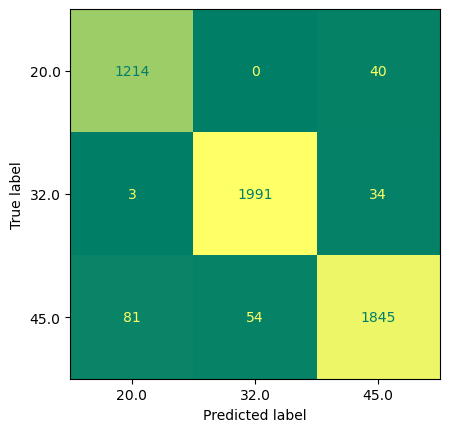

In [162]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay.from_predictions(y_test, pred, colorbar=False, cmap="summer")

<Axes: >

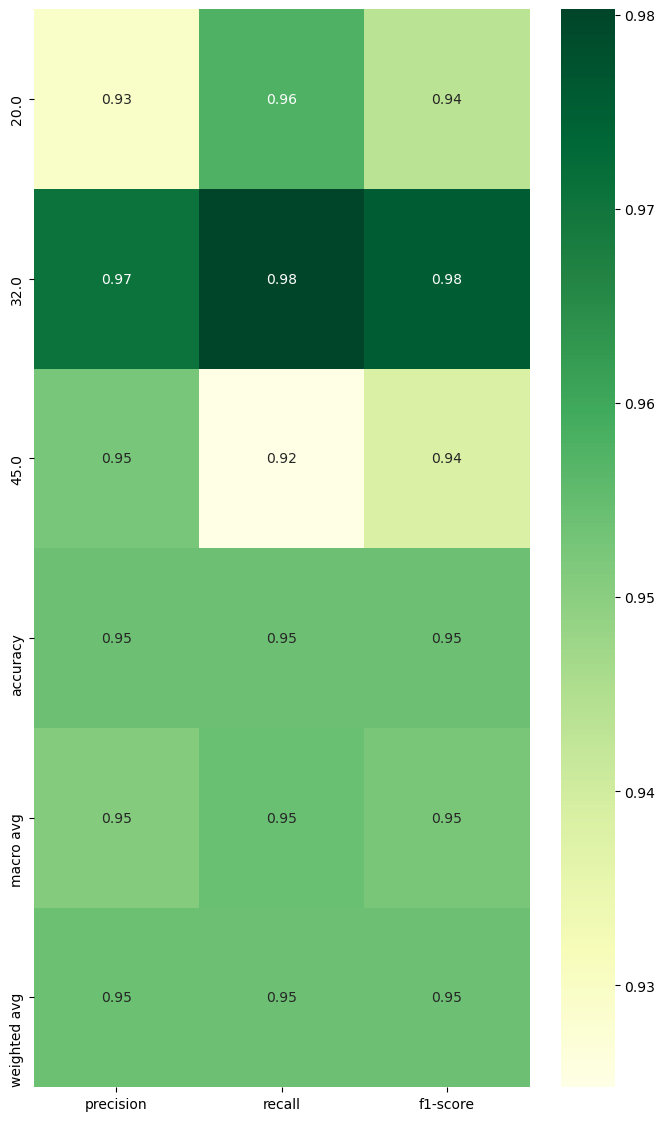

In [76]:
import seaborn as sns

y_hat = svm_clf.predict(X_test)
clf_report = classification_report(y_test,
                                   y_hat,
                                   output_dict=True)

plt.figure(figsize=(8, 14))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="YlGn")

In [74]:
pd.DataFrame(clf_report)

,20.0,32.0,45.0,accuracy,macro avg,weighted avg
precision,0.929567,0.970703,0.952653,0.95401,0.950974,0.954108
recall,0.957735,0.980276,0.924747,0.95401,0.954253,0.954010
f1-score,0.943441,0.975466,0.938493,0.95401,0.952467,0.953922
support,1254.000000,2028.000000,1980.000000,0.95401,5262.000000,5262.000000


In [156]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=2, n_jobs=- 1)

grid.fit(X_train, y_train) 

best_params = grid.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)

pred = svm_clf.predict(X_test)
clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
print("Test Result:n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: n {confusion_matrix(y_test, pred)}n")

Fitting 2 folds for each of 126 candidates, totalling 252 fits
Best params: {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Test Result:n================================================
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:n                  20.0         32.0         45.0  accuracy    macro avg  \
precision     0.936065     0.959924     0.930017  0.943095     0.942002   
recall        0.921134     0.970967     0.928451  0.943095     0.940184   
f1-score      0.928540     0.965414     0.929233  0.943095     0.941062   
support    2257.000000  3651.000000  3564.000000  0.943095  9472.000000   

           weighted avg  
precision      0.942986  
recall         0.943095  
f1-score       0.943014  
support     9472.000000  
_______________________________________________
Confusion Matrix: n [[2079   22  156]
 [  13 3545   93]
 [ 129  126 3309]]n
